In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.0 MB/s eta 0:00:00


In [2]:
#Импорт необходимых библиотек
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.stattools import adfuller


from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from dateutil.parser import parse
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 10})

In [3]:
# тест Дики-Фуллера
# 0 гипотеза: ряд данных не стационарен
# альтернативная гипотеза: ряд данных стационарен
# Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда

def adf_test(series,title=''):

    result = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF тест','p-value','# lags used','# наблюдения']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'критическое значение ({key})']=val

    print(out.to_string())

    if result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы")
        print("Отменяем 0 гипотезу")
        print("Данные стационарны")
    else:
        print("Слабые доказательства против нулевой гипотезы")
        print("Не отменяем 0 гипотезу")
        print("Данные не стационарны")

##Набор данных по производству молока

### Предобработка и визуализация набора данных

In [ ]:
milk_df = pd.read_csv('https://drive.google.com/uc?id=1AbUl7tP_J47ST7L7kc3wxENxmpBUsumS', delimiter = ',', index_col="Month", parse_dates= True)
milk_df.head()

,Unnamed: 0,Monthly milk production (pounds per cow)
Month,,
1962-01-01,0,589
1962-02-01,1,561
1962-03-01,2,640
1962-04-01,3,656
1962-05-01,4,727


In [ ]:
milk_df = milk_df.drop('Unnamed: 0', axis = 1)

In [ ]:
milk_df.rename(columns={"Monthly milk production (pounds per cow)":'Monthly milk production'}, inplace=True)

In [ ]:
milk_df.isna().sum()

Monthly milk production    0
dtype: int64

In [ ]:
milk_df.describe()

,Monthly milk production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


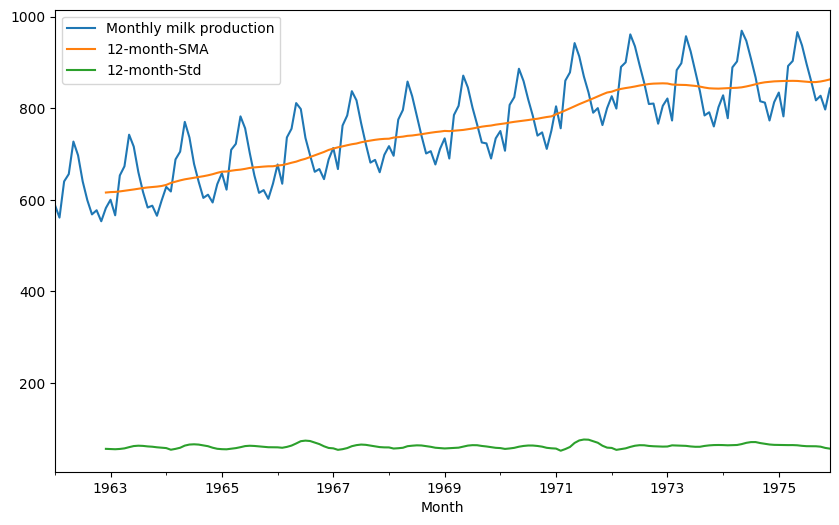

In [ ]:
milk_df['12-month-SMA'] = milk_df['Monthly milk production'].rolling(window=12).mean()
milk_df['12-month-Std'] = milk_df['Monthly milk production'].rolling(window=12).std()

milk_df[['Monthly milk production','12-month-SMA','12-month-Std']].plot();

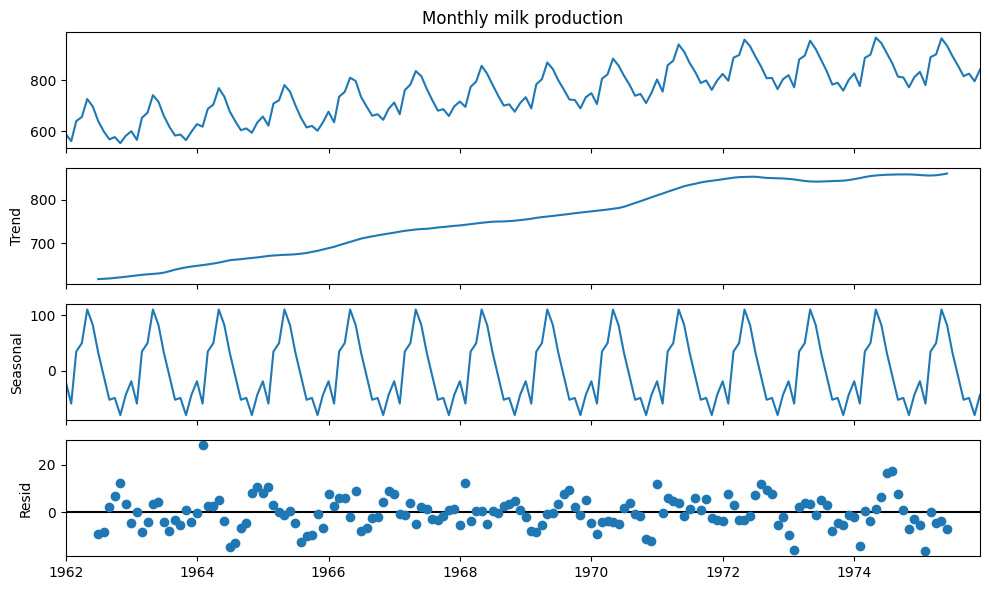

In [ ]:
# сезонная декомпозиция
ssn = seasonal_decompose(milk_df["Monthly milk production"], model="add")
ssn.plot();

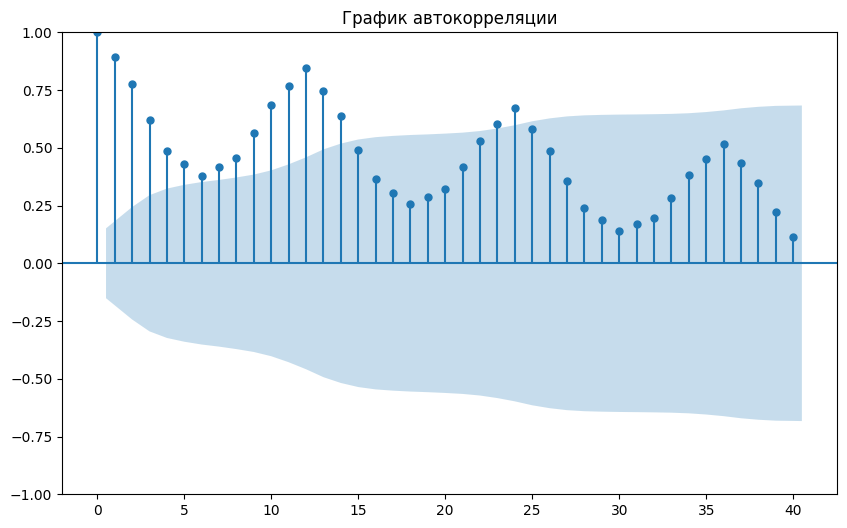

In [ ]:
# ACF
plot_acf(milk_df["Monthly milk production"], title='График автокорреляции', lags=40)
plt.show()

In [ ]:
# Проверка стационарности
adf_test(milk_df["Monthly milk production"])

ADF тест                       -1.303812
p-value                         0.627427
# lags used                    13.000000
# наблюдения                  154.000000
критическое значение (1%)      -3.473543
критическое значение (5%)      -2.880498
критическое значение (10%)     -2.576878
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


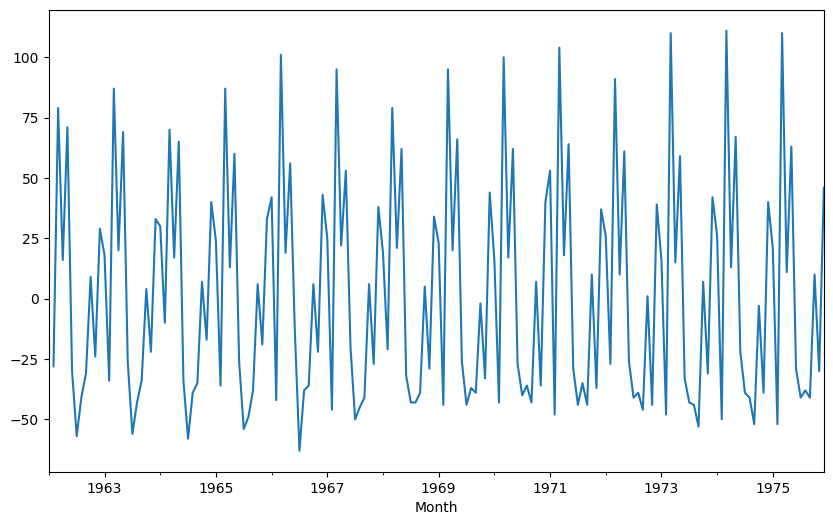

In [ ]:
#Приведение ряда к стационарному
milk_df["difference_1"]= diff(milk_df["Monthly milk production"], k_diff=1)
fig = milk_df["difference_1"].plot()

In [ ]:
# Проверка стационарности
adf_test(milk_df["difference_1"])

ADF тест                       -3.054996
p-value                         0.030068
# lags used                    14.000000
# наблюдения                  152.000000
критическое значение (1%)      -3.474121
критическое значение (5%)      -2.880750
критическое значение (10%)     -2.577013
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


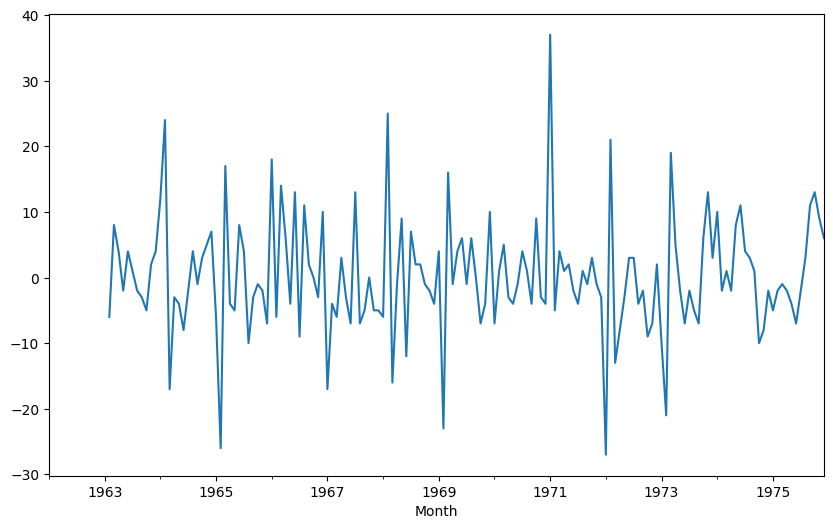

In [ ]:
# Cтационарность после сезонной разности
milk_df["difference_seasonal"]= diff(milk_df["Monthly milk production"], k_diff=1, k_seasonal_diff= 1,seasonal_periods= 12)
fig = milk_df["difference_seasonal"].plot()

In [ ]:
adf_test(milk_df["difference_seasonal"])

ADF тест                       -5.038002
p-value                         0.000019
# lags used                    11.000000
# наблюдения                  143.000000
критическое значение (1%)      -3.476927
критическое значение (5%)      -2.881973
критическое значение (10%)     -2.577665
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


### Поиск параметров и обучение

In [ ]:
#Разделение на тестовый и тренировочный набор данных
train= milk_df.iloc[:len(milk_df)-12]
test= milk_df.iloc[len(milk_df)-12:]

In [ ]:
smodel = auto_arima(train["Monthly milk production"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1203.992, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1218.095, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1015.855, Time=1.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1104.312, Time=1.69 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1349.320, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1039.187, Time=0.54 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1006.896, Time=4.59 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1001.453, Time=2.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1001.195, Time=0.83 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=999.197, Time=0.91 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1001.194, Time=1.99 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=7.98 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=994.889, Time=0.91 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1035.695, Time=0.18 sec
 ARIMA(2,0,0)(1,1,1)[12] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -490.431
Date:                            Thu, 20 Jun 2024   AIC                            994.862
Time:                                    18:38:37   BIC                           1015.650
Sample:                                01-01-1962   HQIC                          1003.309
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3091      2.038      1.623      0.105      -0.686       7.304
ar.L1         -0.2335      0.096     -2.430      0.015      -0.422      -0.045
ar.L2          0.8181      0.077     10.611      0.000       0.667       0.969
ar.L3          0.2510      0.096      2.619      0.009       0.063       0.439
ma.L1          0.9588      0.071     13.599      0.000       0.821       1.097
ma.S.L12      -0.6026      0.087     -6.947      0.000      -0.773      -0.433
sigma2        50.4394      5.268      9.575      0.000      40.115      60.764
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                50.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.84
Prob(H) (two-sided):                  0.34   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

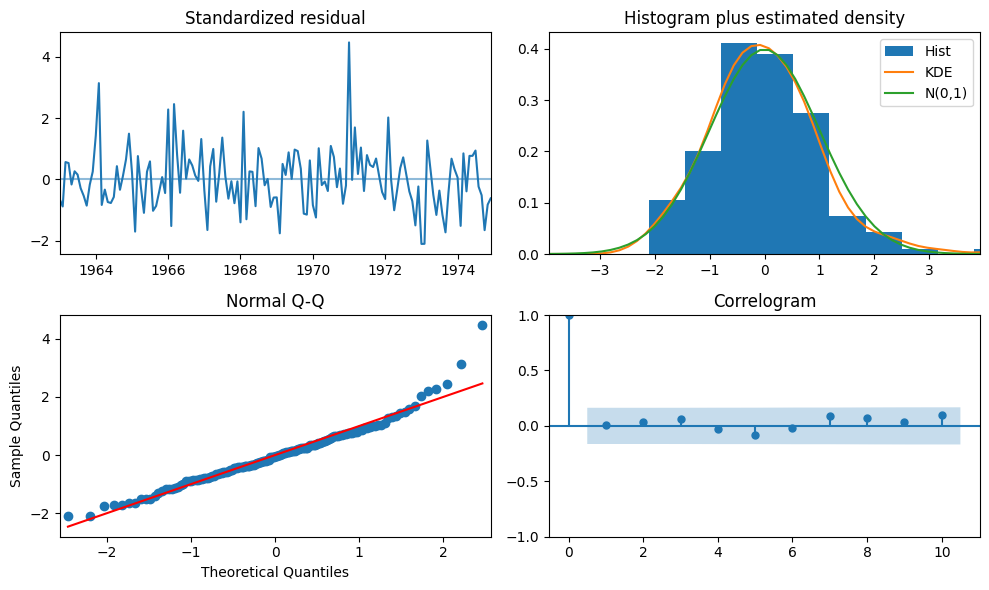

In [ ]:
smodel.plot_diagnostics()
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


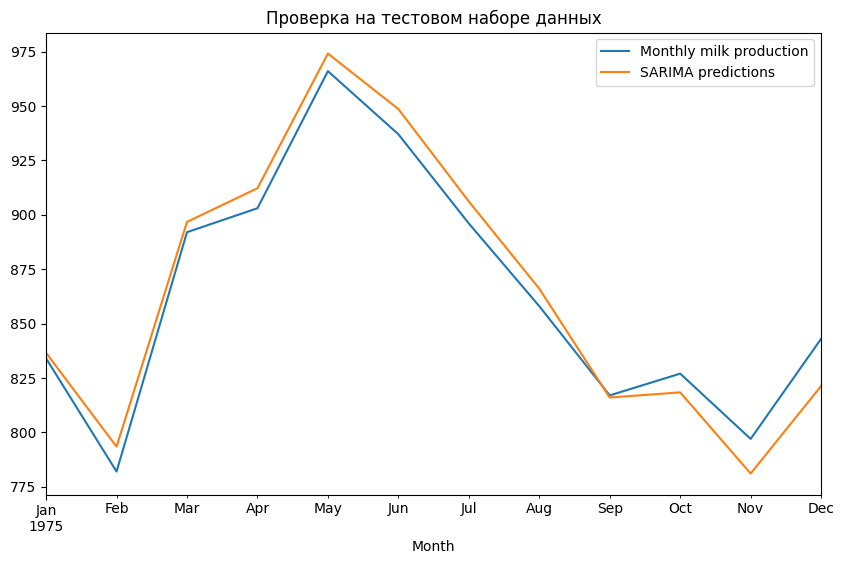

In [ ]:
#Обучение
sarima_model= SARIMAX(train["Monthly milk production"], order= (3,0,1), seasonal_order= (0,1,1,12))
sarima_model_fit= sarima_model.fit()

#Прогноз
start= len(train)
end= len(train) + len(test) - 1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

#Построение графика
test["Monthly milk production"].plot(title= 'Проверка на тестовом наборе данных', legend=True)
fog = pred.plot(legend=True)


In [ ]:
#Оценка модели
mse= mean_squared_error(test["Monthly milk production"],pred)
rmse_sarima= rmse(test["Monthly milk production"], pred)

print(f"RMSE = {rmse_sarima}")
print(f"MSE = {mse}")

RMSE = 10.836299800637837 

MSE = 117.42539336930365


## Набор данных по количеству пассажиров

### Предобработка и визуализация набора данных

In [19]:
ps_df = pd.read_csv('https://drive.google.com/uc?id=1yfw6gcgmJXCtxkjC69ekUvsEtAiYTlST', delimiter = ',', index_col="Month", parse_dates= True)
ps_df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [20]:
ps_df.rename(columns={"#Passengers":'Passengers'}, inplace=True)

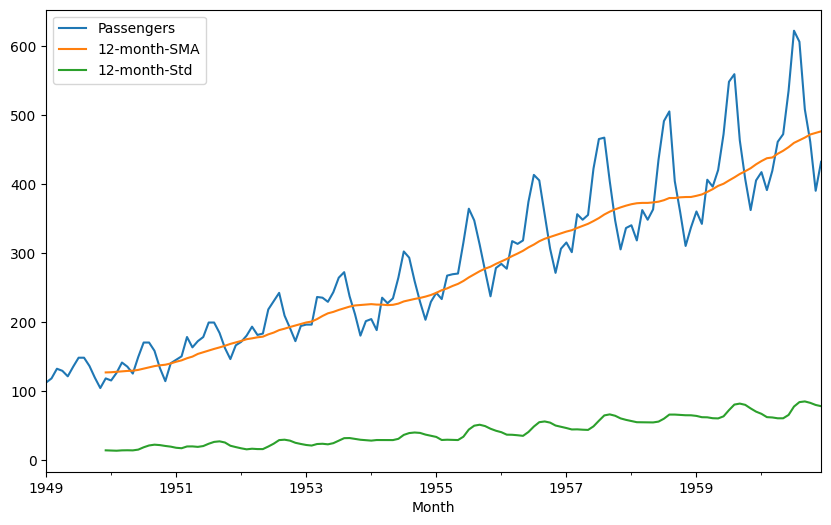

In [ ]:
ps_df['12-month-SMA'] = ps_df['Passengers'].rolling(window=12).mean()
ps_df['12-month-Std'] = ps_df['Passengers'].rolling(window=12).std()

ps_df[['Passengers','12-month-SMA','12-month-Std']].plot();

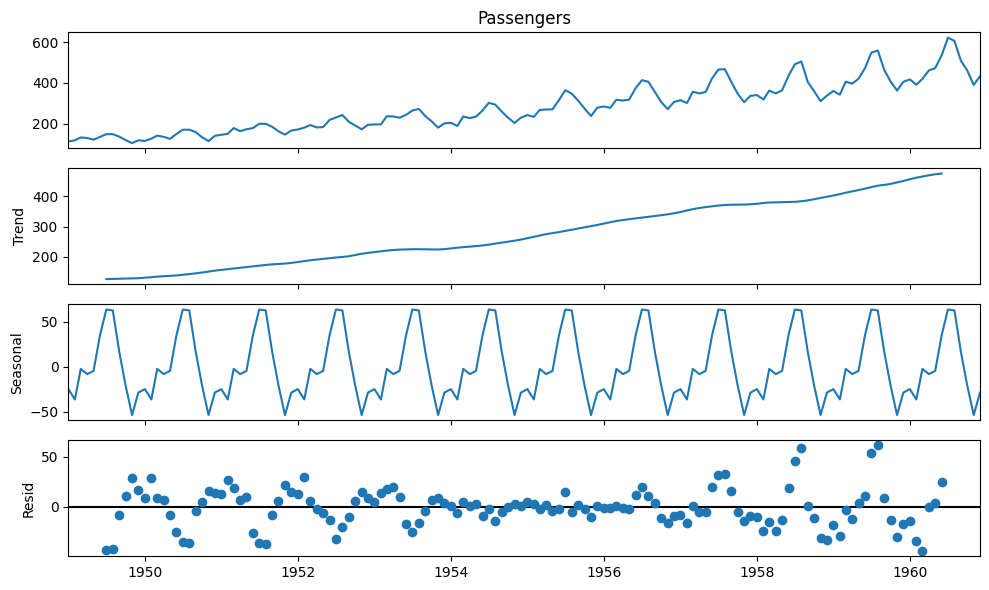

In [ ]:
# сезонная декомпозиция
ssn = seasonal_decompose(ps_df["Passengers"], model="add")
ssn.plot();

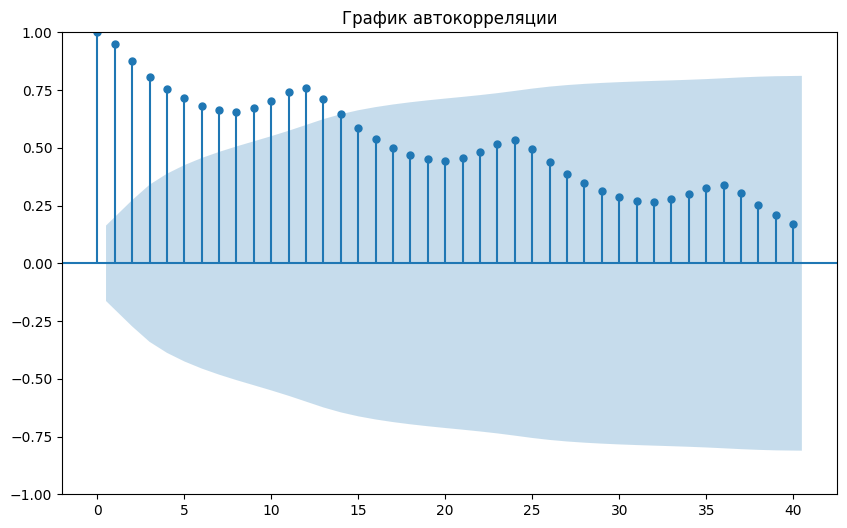

In [ ]:
# ACF
plot_acf(ps_df["Passengers"], title='График автокорреляции', lags=40)
plt.show()

In [ ]:
# Проверка стационарности
adf_test(ps_df["Passengers"])

ADF тест                        0.815369
p-value                         0.991880
# lags used                    13.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


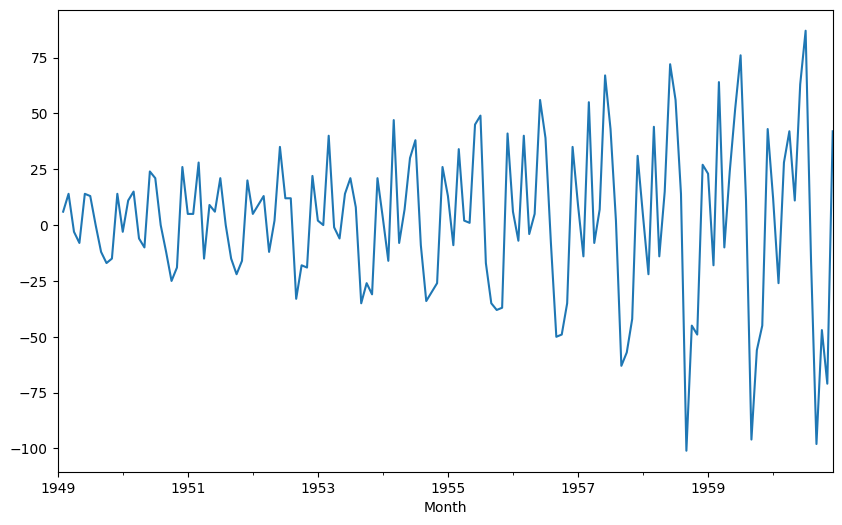

In [ ]:
#Приведение ряда к стационарному
ps_df["difference_1"]= diff(ps_df["Passengers"], k_diff=1)
fig = ps_df["difference_1"].plot()

In [ ]:
# Проверка стационарности
adf_test(ps_df["difference_1"])

ADF тест                       -2.829267
p-value                         0.054213
# lags used                    12.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


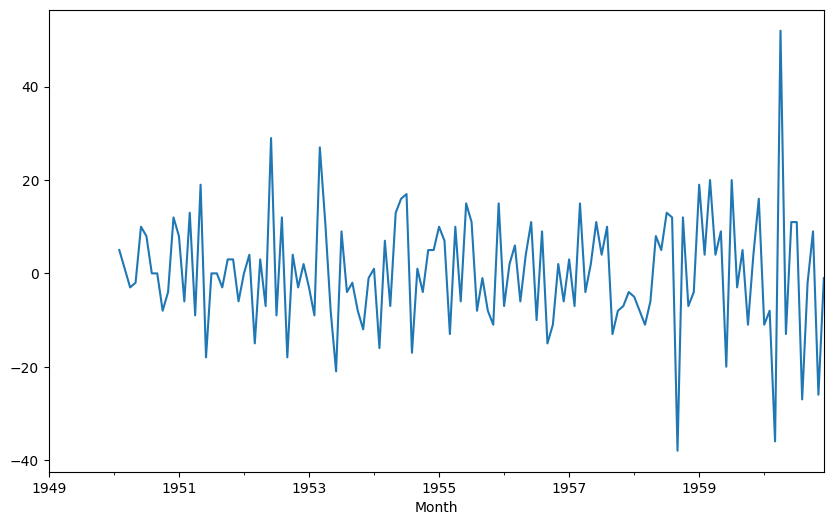

In [ ]:
# Cтационарность после сезонной разности
ps_df["difference_seasonal"]= diff(ps_df["Passengers"], k_diff=1, k_seasonal_diff= 1,seasonal_periods= 12)
fig = ps_df["difference_seasonal"].plot()

In [ ]:
adf_test(ps_df["difference_seasonal"])

ADF тест                     -1.559562e+01
p-value                       1.856512e-28
# lags used                   0.000000e+00
# наблюдения                  1.300000e+02
критическое значение (1%)    -3.481682e+00
критическое значение (5%)    -2.884042e+00
критическое значение (10%)   -2.578770e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


### Поиск параметров и обучение

In [21]:
#Разделение на тестовый и тренировочный набор данных
train= ps_df.iloc[:len(ps_df)-12]
test= ps_df.iloc[len(ps_df)-12:]

In [23]:
smodel = auto_arima(train["Passengers"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.99 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.98 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=3.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.24 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=1.04 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.42 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.60 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=1.15 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.45 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=1.27 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Fri, 21 Jun 2024   AIC                            905.686
Time:                                    09:00:24   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

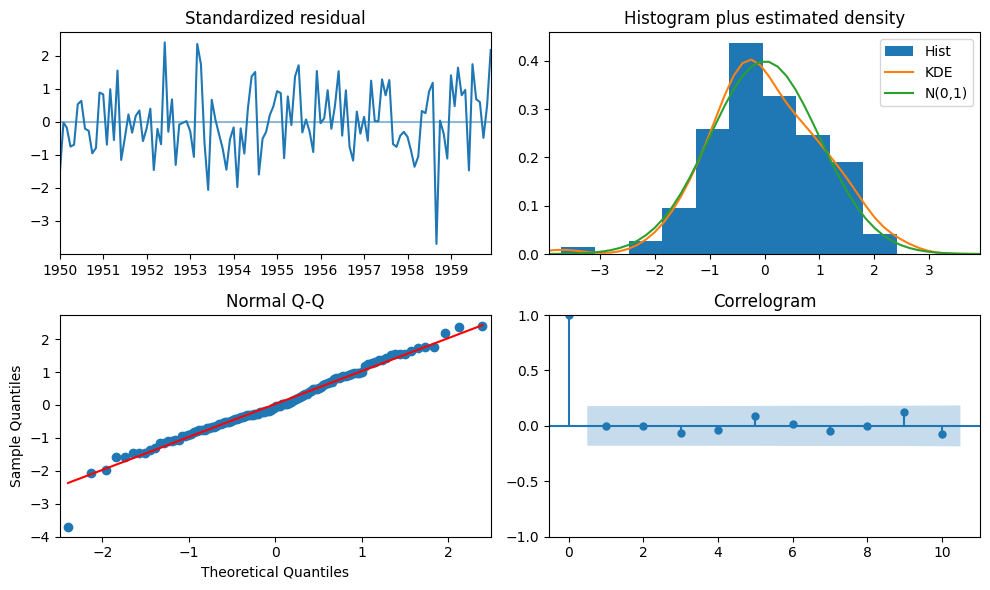

In [24]:
smodel.plot_diagnostics()
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


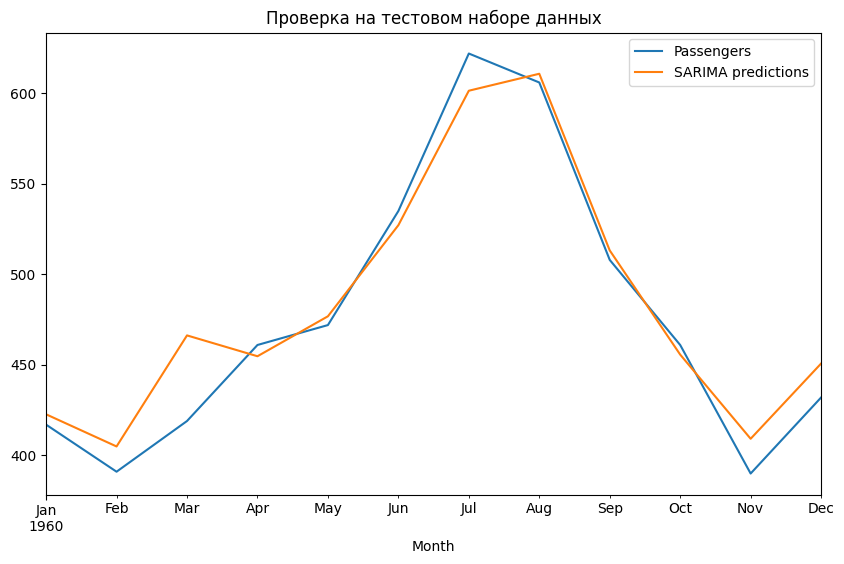

In [25]:
#Обучение
sarima_model= SARIMAX(train["Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12))
sarima_model_fit= sarima_model.fit()

#Прогноз
start= len(train)
end= len(train) + len(test) - 1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

#Построение графика
test["Passengers"].plot(title= 'Проверка на тестовом наборе данных', legend=True)
fog = pred.plot(legend=True)


In [26]:
#Оценка модели
mse= mean_squared_error(test["Passengers"],pred)
rmse_sarima= rmse(test["Passengers"], pred)

print(f"RMSE = {rmse_sarima}")
print(f"MSE = {mse}")

RMSE = 17.81560143047715
MSE = 317.39565432961956


##Набор данных по количеству сотрудников

### Предобработка и визуализация набора данных

In [5]:
emp_df = pd.read_csv('https://drive.google.com/uc?id=1wMwd2mV_nchXgaz3QTPSBl7Xd-ITsPVQ', delimiter = ',', index_col="date", parse_dates= True)
emp_df.head()

,people_employed
date,
1978-01-01,5985.7
1978-02-01,6040.6
1978-03-01,6054.2
1978-04-01,6038.3
1978-05-01,6031.3


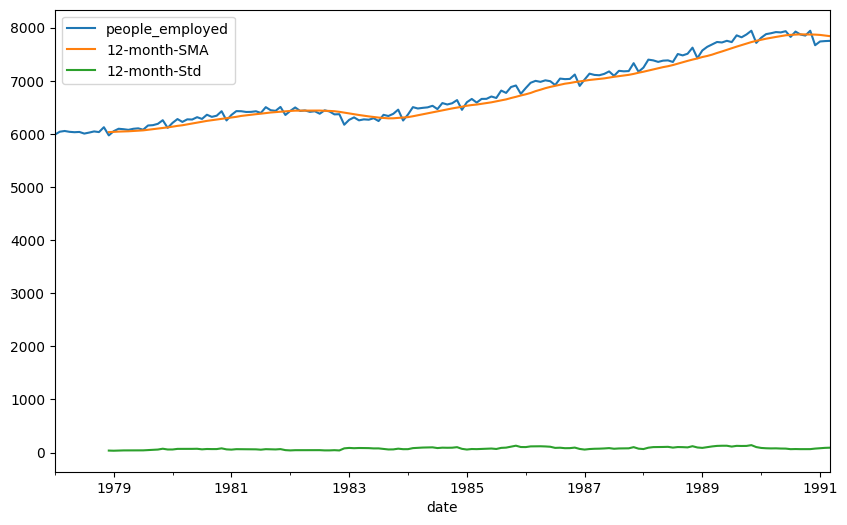

In [7]:
emp_df['12-month-SMA'] = emp_df['people_employed'].rolling(window=12).mean()
emp_df['12-month-Std'] = emp_df['people_employed'].rolling(window=12).std()

emp_df[['people_employed','12-month-SMA','12-month-Std']].plot();

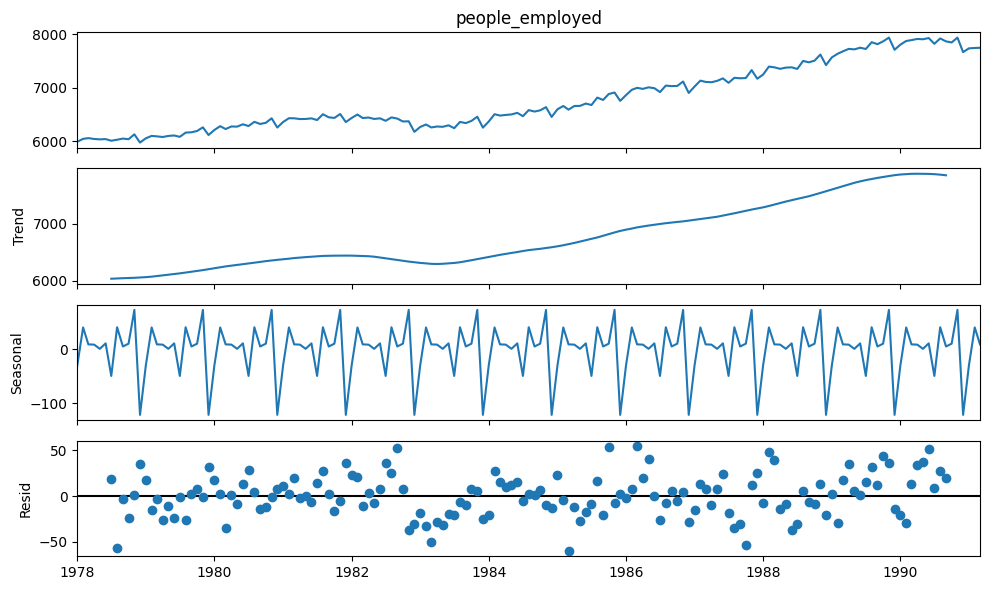

In [8]:
# сезонная декомпозиция
ssn = seasonal_decompose(emp_df["people_employed"], model="add")
ssn.plot();

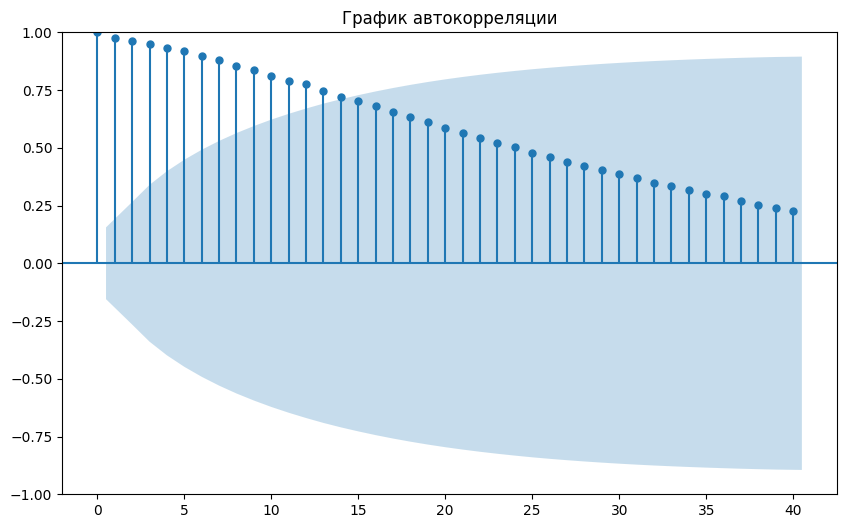

In [9]:
# ACF
plot_acf(emp_df["people_employed"], title='График автокорреляции', lags=40)
plt.show()

In [10]:
# Проверка стационарности
adf_test(emp_df["people_employed"])

ADF тест                       -1.400145
p-value                         0.582207
# lags used                    13.000000
# наблюдения                  145.000000
критическое значение (1%)      -3.476273
критическое значение (5%)      -2.881688
критическое значение (10%)     -2.577513
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


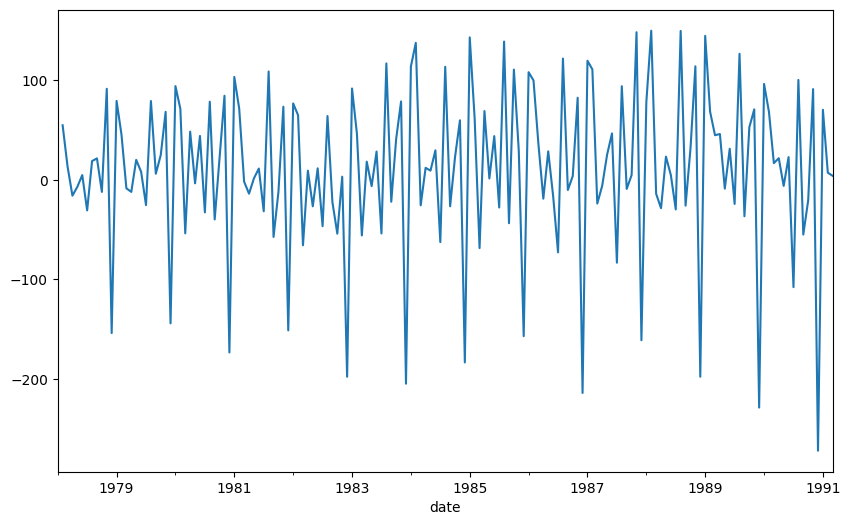

In [27]:
#Приведение ряда к стационарному
emp_df["difference_1"]= diff(emp_df["people_employed"], k_diff=1)
fig = emp_df["difference_1"].plot()

### Поиск параметров и обучение

In [28]:
#Разделение на тестовый и тренировочный набор данных
train= emp_df.iloc[:len(emp_df)-12]
test= emp_df.iloc[len(emp_df)-12:]

In [29]:
smodel = auto_arima(train["people_employed"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1615.725, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1698.275, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1494.908, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1589.529, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1700.112, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1667.292, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1456.152, Time=0.93 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1593.738, Time=0.42 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1458.067, Time=2.28 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1550.728, Time=2.06 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1459.762, Time=0.58 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  147
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -723.334
Date:                              Fri, 21 Jun 2024   AIC                           1454.669
Time:                                      09:29:38   BIC                           1466.603
Sample:                                  01-01-1978   HQIC                          1459.518
                                       - 03-01-1990                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1905      0.081     -2.358      0.018      -0.349      -0.032
ar.S.L12       0.9916      0.008    130.327      0.000       0.977       1.006
ma.S.L12      -0.7088      0.094     -7.508      0.000      -0.894      -0.524
sigma2       974.4366    106.830      9.121      0.000     765.053    1183.820
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.92   Prob(JB):                         0.24
Heteroskedasticity (H):               2.02   Skew:                             0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

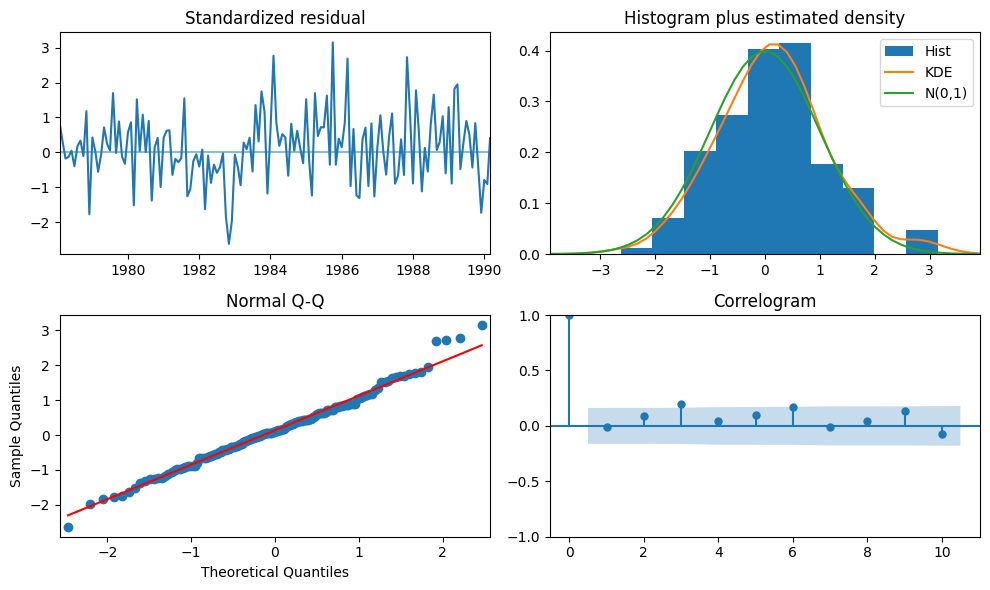

In [13]:
smodel.plot_diagnostics()
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


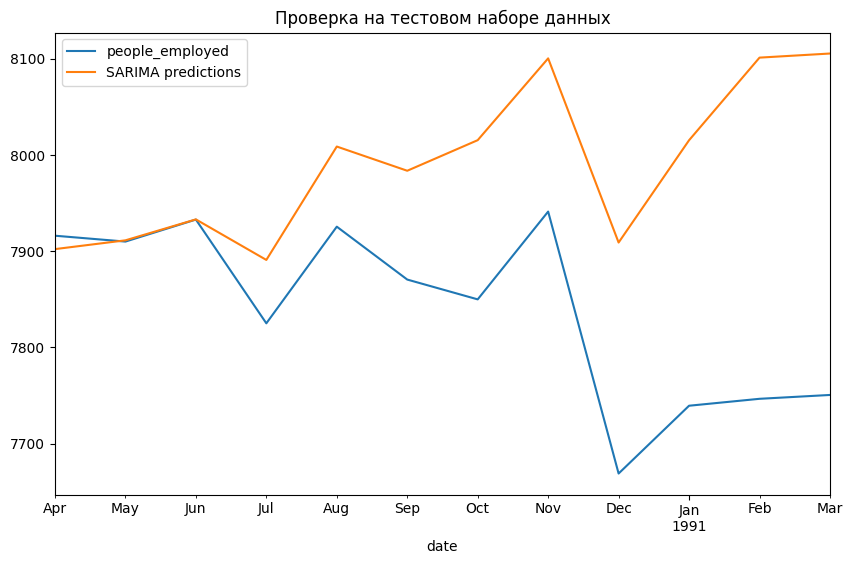

In [16]:
#Обучение
sarima_model= SARIMAX(train["people_employed"], order= (1,1,0), seasonal_order= (1,0,1,12))
sarima_model_fit= sarima_model.fit()

#Прогноз
start= len(train)
end= len(train) + len(test) - 1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

#Построение графика
test["people_employed"].plot(title= 'Проверка на тестовом наборе данных', legend=True)
fog = pred.plot(legend=True)


In [18]:
#Оценка модели
mse= mean_squared_error(test["people_employed"],pred)
rmse_sarima= rmse(test["people_employed"], pred)

print(f"RMSE = {rmse_sarima}")
print(f"MSE = {mse}")

RMSE = 196.41636662058906
MSE = 38579.389076433654
